## Bayesian parameter estimation using MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import *
from UQpy.RunModel import RunModel # required to run the quadratic model
from sklearn.neighbors import KernelDensity # for the plots
from statsmodels.nonparametric.kde import KDEUnivariate

## Probability model

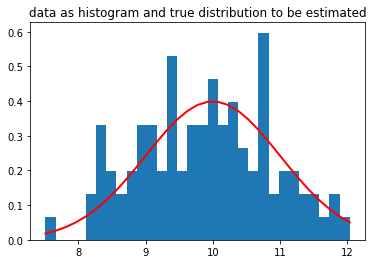

In [2]:
# Generate data from a probability model, here a Gaussian pdf, then learn its parameters, 
# mean and covariance, from this data

np.random.seed(100)
mu, sigma = 10, 1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 100)
np.random.seed()

# plot the data and true distribution
count, bins, ignored = plt.hist(data, 30, normed=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('data as histogram and true distribution to be estimated')
plt.show()

In [3]:
# create an instance of class Model
candidate_model = Model(model_type = 'pdf', model_name='normal', 
                        prior_name = ['uniform','lognormal'], prior_params = [[0, 15], [1, 0, 1]])

In [5]:
# Learn the unknown parameters using MCMC
bayes_estimator = BayesParameterEstimation(data=data, sampling_method = 'MCMC', nsamples=500, 
                                           pdf_proposal = 'Normal', pdf_proposal_scale=[1, 1], model=candidate_model, 
                                           algorithm = 'MH', jump=10, nburn=10, 
                                           seed=np.array([1.0, 0.2]))

Successful execution of the MCMC design


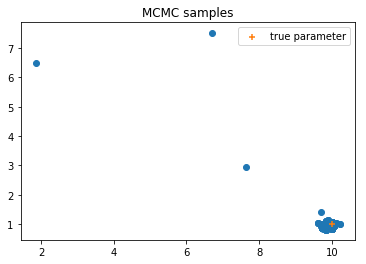

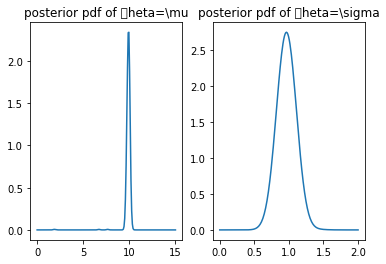

In [6]:
# print results
s = bayes_estimator.samples
plt.scatter(s[:,0],s[:,1])
plt.scatter(10, 1, marker = '+', label='true parameter')
plt.title('MCMC samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(1,2)

domain = np.linspace(0, 15, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,0].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[0].plot(domain, np.exp(log_dens))
ax[0].set_title('posterior pdf of \theta=\mu')

domain = np.linspace(0, 2, 200)[:, np.newaxis]
bandwidth = 1.06*np.std(s[:,0])*s[:,0].shape[0]**(-1/5)
kde = KernelDensity(bandwidth=bandwidth).fit(s[:,1].reshape((-1,1)))
log_dens = kde.score_samples(domain)
ax[1].plot(domain, np.exp(log_dens))
ax[1].set_title('posterior pdf of \theta=\sigma')

plt.show()

## R